In [1]:
## Import packages
import os
import mne
import numpy as np
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt

from scipy.signal import butter, sosfiltfilt, sosfreqz  
from scipy.io import loadmat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, roc_curve, auc

import scripts.classification_utils as utils
import scripts.CSP as csp
import scripts.SACSP as sacsp

In [2]:
## Define directories
data_dir = '/home/inffzy/Desktop/cogs189/cogs189_final_project/data'
results_dir = '/home/inffzy/Desktop/cogs189/cogs189_final_project/results'

In [3]:
## Raw data directory names
bc4_2a_processed_name = 'bci_competition_4_2a_processed'
bc3_3a_processed_name = 'bci_competition_3_3a_processed'

## Create list of all data paths
bc4_2a_processed_data_paths = []
bc3_3a_processed_data_paths = []

## Add bc4_2a data paths
for subject_idx in range(1, 10):
    subject_name = 'A0' + str(subject_idx) + 'T'
    bc4_2a_processed_data_paths.append(
        os.path.join(data_dir, bc4_2a_processed_name, subject_name + '.npz'))
    
## Add bc3_3a data paths
for subject_idx in range(1, 4):
    subject_name = 'bc3_3a_s' + str(subject_idx)
    bc3_3a_processed_data_paths.append(
        os.path.join(data_dir, bc3_3a_processed_name, subject_name + '.npz'))
    
all_data_paths = bc4_2a_processed_data_paths + bc3_3a_processed_data_paths

In [4]:
## Define constants
sampling_f = 250
label_left_hand = 769
label_right_hand = 770
num_samples = 10
test_split = 0.33
random_state = 42
num_cross_val = 5
num_experiment = 10

## Regular CSP Visualization

(138, 22, 500)
(138, 22)


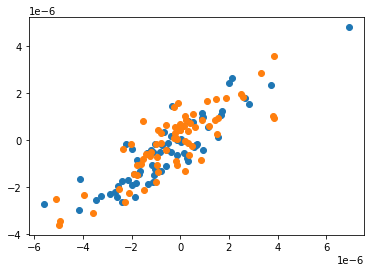

In [5]:
data_npz = np.load(all_data_paths[0])
data = data_npz['processed_motor_imagery_data']
labels = data_npz['descriptions']

## Extract left and right hand epochs
data = data[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
labels = labels[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]

print(data.shape)

data_ds = np.mean(data, axis=-1)
print(data_ds.shape)

data_ds_c1 = data_ds[labels == label_left_hand]
data_ds_c2 = data_ds[labels == label_right_hand]

plt.scatter(data_ds_c1[:, 0], data_ds_c1[:, 1])
plt.scatter(data_ds_c2[:, 0], data_ds_c2[:, 1])

(138, 2, 500)
(138, 2)


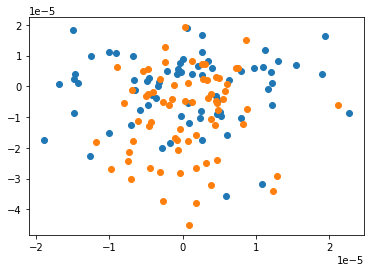

In [6]:
data_c1 = data[labels == label_left_hand]
data_c2 = data[labels == label_right_hand]
csp_transform = csp.CSP(data_c1, data_c2, n_top=1)
data_ = csp.apply_CSP_transform(data, csp_transform)

print(data_.shape)

data_ds = np.mean(data_, axis=-1)
print(data_ds.shape)

data_ds_c1 = data_ds[labels == label_left_hand]
data_ds_c2 = data_ds[labels == label_right_hand]

plt.scatter(data_ds_c1[:, 0], data_ds_c1[:, 1])
plt.scatter(data_ds_c2[:, 0], data_ds_c2[:, 1])

In [7]:
extracted_features = csp.CSP_extract_features(data, csp_transform, n_top=1)

In [8]:
extracted_features.shape

(138, 2)

(138, 2, 500)
(138, 2)


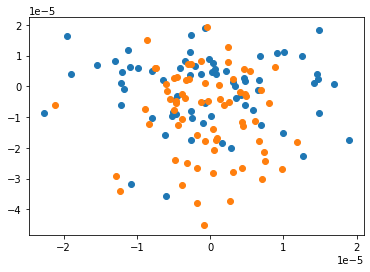

In [9]:
data_c1 = data[labels == label_left_hand]
data_c2 = data[labels == label_right_hand]
csp_transform = csp.CSP2(data_c1, data_c2, n_top=1)
data_ = csp.apply_CSP_transform(data, csp_transform)

print(data_.shape)

data_ds = np.mean(data_, axis=-1)
print(data_ds.shape)

data_ds_c1 = data_ds[labels == label_left_hand]
data_ds_c2 = data_ds[labels == label_right_hand]

plt.scatter(data_ds_c1[:, 0], data_ds_c1[:, 1])
plt.scatter(data_ds_c2[:, 0], data_ds_c2[:, 1])

In [10]:
data_c1 = data[labels == label_left_hand]
data_c2 = data[labels == label_right_hand]

c1_filter_pairs, c2_filter_pairs = sacsp.SACSP2(data_c1, data_c2)

/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


In [11]:
len(c1_filter_pairs)

3

In [12]:
c1_spectral_filter1 = c1_filter_pairs[0][0]
c1_spectral_filter2 = c1_filter_pairs[1][0]
c1_spectral_filter3 = c1_filter_pairs[2][0]

c2_spectral_filter1 = c2_filter_pairs[0][0]
c2_spatial_filter1 = c2_filter_pairs[0][1]

print(c1_spectral_filter1.shape)

(500,)


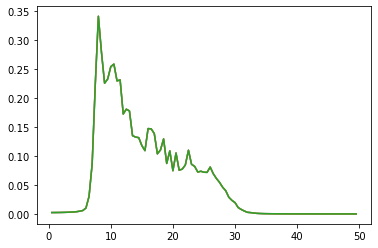

In [13]:
freq = np.fft.fftfreq(500) * sampling_f

f1 = c1_spectral_filter1[1:100]
f2 = c1_spectral_filter2[1:100]
f3 = c1_spectral_filter3[1:100]

plt.plot(freq[1:100], f1 / np.linalg.norm(f1))
plt.plot(freq[1:100], f2 / np.linalg.norm(f2))
plt.plot(freq[1:100], f3 / np.linalg.norm(f3))

In [14]:
freq = np.fft.fftfreq(500) * 250
np.all([freq >= 7, freq <= 15], axis=0) 

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [15]:
freq

array([   0. ,    0.5,    1. ,    1.5,    2. ,    2.5,    3. ,    3.5,
          4. ,    4.5,    5. ,    5.5,    6. ,    6.5,    7. ,    7.5,
          8. ,    8.5,    9. ,    9.5,   10. ,   10.5,   11. ,   11.5,
         12. ,   12.5,   13. ,   13.5,   14. ,   14.5,   15. ,   15.5,
         16. ,   16.5,   17. ,   17.5,   18. ,   18.5,   19. ,   19.5,
         20. ,   20.5,   21. ,   21.5,   22. ,   22.5,   23. ,   23.5,
         24. ,   24.5,   25. ,   25.5,   26. ,   26.5,   27. ,   27.5,
         28. ,   28.5,   29. ,   29.5,   30. ,   30.5,   31. ,   31.5,
         32. ,   32.5,   33. ,   33.5,   34. ,   34.5,   35. ,   35.5,
         36. ,   36.5,   37. ,   37.5,   38. ,   38.5,   39. ,   39.5,
         40. ,   40.5,   41. ,   41.5,   42. ,   42.5,   43. ,   43.5,
         44. ,   44.5,   45. ,   45.5,   46. ,   46.5,   47. ,   47.5,
         48. ,   48.5,   49. ,   49.5,   50. ,   50.5,   51. ,   51.5,
         52. ,   52.5,   53. ,   53.5,   54. ,   54.5,   55. ,   55.5,
      

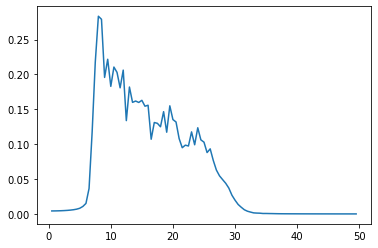

In [16]:
signal = c2_spectral_filter1[1:100]
plt.plot(freq[1:100], signal / np.linalg.norm(signal))

### Note: each of the following classification experiment is run 10 times, each with a different random seed

## Binary Classification with LDA

In [17]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((num_experiment, len(all_data_paths), 3))

for j in range(num_experiment):
    for i, data_path in enumerate(all_data_paths):
        
        ## Load data
        data_npz = np.load(data_path)
        data = data_npz['processed_motor_imagery_data']
        labels = data_npz['descriptions']
        
        ## Extract left and right hand epochs
        data = data[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
        labels = labels[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
    
        ## Downsample with windowed means
        data_ds = utils.windowed_means(data, num_samples)
        
        ## Flatten data
        data_ds_flattened = utils.flatten_dim12(data_ds)
        
        ## Prepare training and testing data
        X_train, X_test, y_train, y_test = train_test_split(data_ds_flattened, 
                                                            labels, 
                                                            test_size=test_split, 
                                                            shuffle=True,
                                                            random_state=j)
        
        ## Classification
        clf = utils.LDA_classifier(X_train, y_train, cross_val=num_cross_val)
        cross_val_score_avg = clf.train_binary()
        predictions, train_accuracy = clf.test_binary()
        predictions, test_accuracy = clf.test_binary(X_test, y_test)
        results[j, i, :] = [train_accuracy, cross_val_score_avg, test_accuracy]

Cross validation score average:  0.5771929824561404
Training accuracy:  0.9347826086956522
Testing accuracy:  0.6086956521739131
Cross validation score average:  0.47134502923976607
Training accuracy:  0.9230769230769231
Testing accuracy:  0.4666666666666667
Cross validation score average:  0.5403508771929825
Training accuracy:  0.8791208791208791
Testing accuracy:  0.45652173913043476
Cross validation score average:  0.5117647058823529
Training accuracy:  0.8837209302325582
Testing accuracy:  0.4186046511627907
Cross validation score average:  0.5
Training accuracy:  0.8255813953488372
Testing accuracy:  0.4186046511627907
Cross validation score average:  0.5333333333333333
Training accuracy:  0.96
Testing accuracy:  0.34210526315789475
Cross validation score average:  0.515686274509804
Training accuracy:  0.7865168539325843
Testing accuracy:  0.5
Cross validation score average:  0.5464052287581699
Training accuracy:  0.9090909090909091
Testing accuracy:  0.6136363636363636
Cross vali

Cross validation score average:  0.5222222222222223
Training accuracy:  1.0
Testing accuracy:  0.36
Cross validation score average:  0.6761904761904762
Training accuracy:  1.0
Testing accuracy:  0.625
Cross validation score average:  0.6266666666666667
Training accuracy:  1.0
Testing accuracy:  0.5
Cross validation score average:  0.5128654970760234
Training accuracy:  0.8804347826086957
Testing accuracy:  0.6521739130434783
Cross validation score average:  0.4269005847953216
Training accuracy:  0.8681318681318682
Testing accuracy:  0.4
Cross validation score average:  0.6052631578947368
Training accuracy:  0.978021978021978
Testing accuracy:  0.5434782608695652
Cross validation score average:  0.5359477124183006
Training accuracy:  0.872093023255814
Testing accuracy:  0.5116279069767442
Cross validation score average:  0.43006535947712415
Training accuracy:  0.813953488372093
Testing accuracy:  0.5116279069767442
Cross validation score average:  0.4533333333333334
Training accuracy:  

In [18]:
print(results)
results_avg = np.mean(results, axis=0)
print(results_avg)

results_path = os.path.join(results_dir, '2_LDA.npy')
np.save(results_path, results)

[[[0.93478261 0.57719298 0.60869565]
  [0.92307692 0.47134503 0.46666667]
  [0.87912088 0.54035088 0.45652174]
  [0.88372093 0.51176471 0.41860465]
  [0.8255814  0.5        0.41860465]
  [0.96       0.53333333 0.34210526]
  [0.78651685 0.51568627 0.5       ]
  [0.90909091 0.54640523 0.61363636]
  [0.96103896 0.46916667 0.56410256]
  [0.97916667 0.43555556 0.6       ]
  [1.         0.58095238 0.5       ]
  [1.         0.28666667 0.5       ]]

 [[0.89130435 0.56608187 0.56521739]
  [0.93406593 0.49298246 0.37777778]
  [0.87912088 0.51695906 0.52173913]
  [0.89534884 0.52418301 0.46511628]
  [0.8372093  0.40457516 0.53488372]
  [0.98666667 0.49333333 0.57894737]
  [0.87640449 0.45947712 0.45454545]
  [0.92045455 0.52156863 0.59090909]
  [0.96103896 0.48       0.66666667]
  [1.         0.49777778 0.44      ]
  [1.         0.67619048 0.625     ]
  [1.         0.56       0.5       ]]

 [[0.83695652 0.49883041 0.58695652]
  [0.9010989  0.42748538 0.42222222]
  [0.93406593 0.57368421 0.4130434

## Binary Classification with Regular CSP + LDA

In [19]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((num_experiment, len(all_data_paths), 3))

for j in range(num_experiment):
    for i, data_path in enumerate(all_data_paths):
        
        ## Load data
        data_npz = np.load(data_path)
        data = data_npz['processed_motor_imagery_data']
        labels = data_npz['descriptions']
        
        ## Extract left and right hand epochs
        data = data[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
        labels = labels[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
        
        ## Prepare training and testing data
        X_train, X_test, y_train, y_test = train_test_split(data, 
                                                            labels, 
                                                            test_size=test_split, 
                                                            shuffle=True,
                                                            random_state=j)
        
        ## Classification
        clf = csp.CSP_LDA_classifier(X_train, y_train, cross_val=num_cross_val)
        cross_val_score_avg = clf.train_binary()
        predictions, train_accuracy = clf.test_binary()
        predictions, test_accuracy = clf.test_binary(X_test, y_test)
        results[j, i, :] = [train_accuracy, cross_val_score_avg, test_accuracy]

Cross validation score average:  0.7818713450292397
Training accuracy:  0.8043478260869565
Testing accuracy:  0.6956521739130435
Cross validation score average:  0.6596491228070175
Training accuracy:  0.7032967032967034
Testing accuracy:  0.5111111111111111
Cross validation score average:  0.956140350877193
Training accuracy:  0.9560439560439561
Testing accuracy:  0.8478260869565217
Cross validation score average:  0.8248366013071895
Training accuracy:  0.8255813953488372
Testing accuracy:  0.5581395348837209
Cross validation score average:  0.592156862745098
Training accuracy:  0.6395348837209303
Testing accuracy:  0.627906976744186
Cross validation score average:  0.8800000000000001
Training accuracy:  0.8933333333333333
Testing accuracy:  0.4473684210526316
Cross validation score average:  0.8183006535947713
Training accuracy:  0.8202247191011236
Testing accuracy:  0.6590909090909091
Cross validation score average:  0.9555555555555555
Training accuracy:  0.9545454545454546
Testing a

Cross validation score average:  0.8058333333333334
Training accuracy:  0.8181818181818182
Testing accuracy:  0.6923076923076923
Cross validation score average:  0.9577777777777777
Training accuracy:  0.9583333333333334
Testing accuracy:  0.88
Cross validation score average:  1.0
Training accuracy:  1.0
Testing accuracy:  0.5
Cross validation score average:  1.0
Training accuracy:  1.0
Testing accuracy:  0.5
Cross validation score average:  0.7742690058479533
Training accuracy:  0.8043478260869565
Testing accuracy:  0.717391304347826
Cross validation score average:  0.6801169590643276
Training accuracy:  0.7472527472527473
Testing accuracy:  0.5777777777777777
Cross validation score average:  0.9023391812865498
Training accuracy:  0.9120879120879121
Testing accuracy:  0.8478260869565217
Cross validation score average:  0.8366013071895425
Training accuracy:  0.8255813953488372
Testing accuracy:  0.5813953488372093
Cross validation score average:  0.6143790849673202
Training accuracy:  0

In [20]:
print(results)
results_avg = np.mean(results, axis=0)
print(results_avg)

results_path = os.path.join(results_dir, '2_LDA_CSP.npy')
np.save(results_path, results)

[[[0.80434783 0.78187135 0.69565217]
  [0.7032967  0.65964912 0.51111111]
  [0.95604396 0.95614035 0.84782609]
  [0.8255814  0.8248366  0.55813953]
  [0.63953488 0.59215686 0.62790698]
  [0.89333333 0.88       0.44736842]
  [0.82022472 0.81830065 0.65909091]
  [0.95454545 0.95555556 0.86363636]
  [0.83116883 0.83166667 0.74358974]
  [0.95833333 0.93555556 0.92      ]
  [1.         0.93809524 0.5625    ]
  [0.88888889 0.88666667 0.78571429]]

 [[0.81521739 0.80292398 0.7826087 ]
  [0.7032967  0.62807018 0.53333333]
  [0.93406593 0.9245614  0.91304348]
  [0.77906977 0.74313725 0.65116279]
  [0.6744186  0.64052288 0.60465116]
  [0.76       0.73333333 0.65789474]
  [0.82022472 0.80849673 0.63636364]
  [0.96590909 0.95490196 0.95454545]
  [0.87012987 0.8725     0.87179487]
  [0.95833333 0.93333333 0.8       ]
  [1.         0.96666667 0.625     ]
  [1.         1.         0.92857143]]

 [[0.76086957 0.7497076  0.7826087 ]
  [0.69230769 0.66900585 0.46666667]
  [0.92307692 0.92280702 0.9130434

## Binary Classification with Spectrally Adaptive CSP + LDA

In [21]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((num_experiment, len(all_data_paths), 3))

for j in range(num_experiment):
    for i, data_path in enumerate(all_data_paths):
        
        ## Load data
        data_npz = np.load(data_path)
        data = data_npz['processed_motor_imagery_data']
        labels = data_npz['descriptions']
        
        ## Extract left and right hand epochs
        data = data[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
        labels = labels[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
        
        ## Prepare training and testing data
        X_train, X_test, y_train, y_test = train_test_split(data, 
                                                            labels, 
                                                            test_size=test_split, 
                                                            shuffle=True,
                                                            random_state=j)
        
        ## Classification
        clf = sacsp.SACSP_LDA_classifier(X_train, y_train, cross_val=num_cross_val)
        cross_val_score_avg = clf.train_binary()
        predictions, train_accuracy = clf.test_binary()
        predictions, test_accuracy = clf.test_binary(X_test, y_test)
        results[j, i, :] = [train_accuracy, cross_val_score_avg, test_accuracy]

/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation score average:  0.5555555555555556


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5760869565217391
Testing accuracy:  0.45652173913043476


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5614035087719299


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5934065934065934
Testing accuracy:  0.4888888888888889


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9444444444444443


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.967032967032967
Testing accuracy:  0.8478260869565217


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5816993464052288


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6162790697674418
Testing accuracy:  0.46511627906976744


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5941176470588235


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6046511627906976
Testing accuracy:  0.4186046511627907


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5466666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6133333333333333
Testing accuracy:  0.34210526315789475


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5065359477124183


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5842696629213483
Testing accuracy:  0.5909090909090909


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9326797385620915


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9318181818181818
Testing accuracy:  0.8636363636363636


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6483333333333332


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6493506493506493
Testing accuracy:  0.717948717948718


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.7911111111111111
Training accuracy:  0.8125


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Testing accuracy:  0.6


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation score average:  0.719047619047619
Training accuracy:  0.7419354838709677
Testing accuracy:  0.5


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.8400000000000001
Training accuracy:  0.8888888888888888
Testing accuracy:  0.5714285714285714


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.552046783625731


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5434782608695652
Testing accuracy:  0.5217391304347826


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5502923976608187


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5714285714285714
Testing accuracy:  0.4


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9005847953216375


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9120879120879121
Testing accuracy:  0.9565217391304348


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5849673202614379


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6162790697674418
Testing accuracy:  0.46511627906976744


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6503267973856209


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6511627906976745
Testing accuracy:  0.5813953488372093


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6133333333333334


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.68
Testing accuracy:  0.4473684210526316


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6156862745098038


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6179775280898876
Testing accuracy:  0.45454545454545453


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9098039215686274


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9204545454545454
Testing accuracy:  0.9318181818181818


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6116666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6233766233766234
Testing accuracy:  0.6923076923076923


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.8755555555555556
Training accuracy:  0.9375


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Testing accuracy:  0.56


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation score average:  0.6476190476190476
Training accuracy:  0.7096774193548387
Testing accuracy:  0.5625


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.96
Training accuracy:  0.9629629629629629
Testing accuracy:  0.7857142857142857


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5871345029239766


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6086956521739131
Testing accuracy:  0.6304347826086957


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6046783625730995


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6263736263736264
Testing accuracy:  0.28888888888888886


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.7789473684210526


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.8021978021978022
Testing accuracy:  0.6956521739130435


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6496732026143792


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6627906976744186
Testing accuracy:  0.4418604651162791


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6176470588235294


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.627906976744186
Testing accuracy:  0.4883720930232558


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6933333333333332


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.76
Testing accuracy:  0.42105263157894735


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5496732026143791


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6179775280898876
Testing accuracy:  0.4090909090909091


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.8986928104575164


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9318181818181818
Testing accuracy:  0.9318181818181818


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6766666666666665


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6883116883116883
Testing accuracy:  0.6923076923076923


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.7533333333333333
Training accuracy:  0.8125


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Testing accuracy:  0.84


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation score average:  0.7666666666666666
Training accuracy:  0.7741935483870968
Testing accuracy:  0.3125


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.8933333333333333
Training accuracy:  0.9629629629629629
Testing accuracy:  1.0


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5023391812865498


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5543478260869565
Testing accuracy:  0.4782608695652174


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5947368421052632


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6263736263736264
Testing accuracy:  0.26666666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.8789473684210527


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.8901098901098901
Testing accuracy:  0.9347826086956522


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5803921568627451


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5581395348837209
Testing accuracy:  0.627906976744186


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6287581699346406


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.627906976744186
Testing accuracy:  0.37209302325581395


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5866666666666667


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.64
Testing accuracy:  0.3157894736842105


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.550326797385621


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5730337078651685
Testing accuracy:  0.5681818181818182


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9202614379084967


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9318181818181818
Testing accuracy:  0.9318181818181818


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.675


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.7012987012987013
Testing accuracy:  0.6666666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.7755555555555556
Training accuracy:  0.7708333333333334


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Testing accuracy:  0.68


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation score average:  0.5809523809523809
Training accuracy:  0.6451612903225806
Testing accuracy:  0.3125


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6933333333333334
Training accuracy:  0.7777777777777778
Testing accuracy:  0.6428571428571429


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.7192982456140351


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.7282608695652174
Testing accuracy:  0.6956521739130435


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6374269005847953


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6483516483516484
Testing accuracy:  0.35555555555555557


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9228070175438597


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.945054945054945
Testing accuracy:  0.9347826086956522


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5117647058823529


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5581395348837209
Testing accuracy:  0.6046511627906976


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.592156862745098


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6744186046511628
Testing accuracy:  0.4186046511627907


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5599999999999999


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6666666666666666
Testing accuracy:  0.4473684210526316


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5169934640522875


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5730337078651685
Testing accuracy:  0.5227272727272727


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9424836601307188


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9318181818181818
Testing accuracy:  0.9318181818181818


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.7533333333333333


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.7792207792207793
Testing accuracy:  0.6410256410256411


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6288888888888888
Training accuracy:  0.75


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Testing accuracy:  0.76


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation score average:  0.5476190476190477
Training accuracy:  0.6451612903225806
Testing accuracy:  0.5625


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.96
Training accuracy:  0.9629629629629629
Testing accuracy:  0.9285714285714286


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.752046783625731


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.7391304347826086
Testing accuracy:  0.6086956521739131


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6263157894736843


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6593406593406593
Testing accuracy:  0.37777777777777777


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.8906432748538012


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9120879120879121
Testing accuracy:  0.8913043478260869


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5104575163398694


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5348837209302325
Testing accuracy:  0.5581395348837209


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5947712418300652


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6744186046511628
Testing accuracy:  0.46511627906976744


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6533333333333334


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6933333333333334
Testing accuracy:  0.6578947368421053


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6862745098039216


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6853932584269663
Testing accuracy:  0.3181818181818182


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.907843137254902


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9431818181818182
Testing accuracy:  0.9318181818181818


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6758333333333334


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.7142857142857143
Testing accuracy:  0.6666666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.7466666666666667
Training accuracy:  0.7916666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Testing accuracy:  0.76


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation score average:  0.7666666666666667
Training accuracy:  0.8387096774193549
Testing accuracy:  0.5625


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.96
Training accuracy:  0.9629629629629629
Testing accuracy:  0.9285714285714286


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.639766081871345


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6739130434782609
Testing accuracy:  0.5434782608695652


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5385964912280701


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5824175824175825
Testing accuracy:  0.4222222222222222


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9116959064327486


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9340659340659341
Testing accuracy:  0.9347826086956522


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5928104575163399


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6046511627906976
Testing accuracy:  0.4883720930232558


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6169934640522876


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.627906976744186
Testing accuracy:  0.5116279069767442


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5866666666666667


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6133333333333333
Testing accuracy:  0.42105263157894735


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.47124183006535947


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5393258426966292
Testing accuracy:  0.4772727272727273


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9202614379084967


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9090909090909091
Testing accuracy:  0.9090909090909091


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.7150000000000001


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.7272727272727273
Testing accuracy:  0.717948717948718


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6799999999999999
Training accuracy:  0.7083333333333334


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Testing accuracy:  0.8


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation score average:  0.6714285714285715
Training accuracy:  0.7096774193548387
Testing accuracy:  0.375


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9666666666666668
Training accuracy:  0.9629629629629629
Testing accuracy:  0.9285714285714286


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5654970760233918


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6086956521739131
Testing accuracy:  0.5652173913043478


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6157894736842106


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6043956043956044
Testing accuracy:  0.4666666666666667


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.8473684210526315


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.8571428571428571
Testing accuracy:  0.7391304347826086


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6379084967320262


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6395348837209303
Testing accuracy:  0.5116279069767442


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6405228758169935


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6976744186046512
Testing accuracy:  0.5116279069767442


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6666666666666666
Testing accuracy:  0.631578947368421


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5490196078431373


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5842696629213483
Testing accuracy:  0.4090909090909091


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9653594771241831


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9659090909090909
Testing accuracy:  0.7954545454545454


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.675


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6753246753246753
Testing accuracy:  0.6666666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.8133333333333332
Training accuracy:  0.8333333333333334


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Testing accuracy:  0.68


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation score average:  0.6142857142857142
Training accuracy:  0.6451612903225806
Testing accuracy:  0.75


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9266666666666667
Training accuracy:  0.9629629629629629
Testing accuracy:  0.9285714285714286


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.4976608187134503


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5543478260869565
Testing accuracy:  0.4782608695652174


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5947368421052632


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6043956043956044
Testing accuracy:  0.4


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.867251461988304


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9010989010989011
Testing accuracy:  0.8478260869565217


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5568627450980392


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5813953488372093
Testing accuracy:  0.5348837209302325


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5699346405228759


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.627906976744186
Testing accuracy:  0.5116279069767442


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.7066666666666667


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6933333333333334
Testing accuracy:  0.47368421052631576


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.44901960784313727


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5617977528089888
Testing accuracy:  0.4090909090909091


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9437908496732026


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9431818181818182
Testing accuracy:  0.8863636363636364


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.7391666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.7792207792207793
Testing accuracy:  0.6666666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.8555555555555555
Training accuracy:  0.8541666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Testing accuracy:  0.72


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation score average:  0.7761904761904762
Training accuracy:  0.8064516129032258
Testing accuracy:  0.5625


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.8933333333333333
Training accuracy:  0.9259259259259259
Testing accuracy:  0.42857142857142855


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.660233918128655


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6847826086956522
Testing accuracy:  0.45652173913043476


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5719298245614035


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6043956043956044
Testing accuracy:  0.5111111111111111


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9333333333333332


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.945054945054945
Testing accuracy:  0.9130434782608695


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.580392156862745


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6046511627906976
Testing accuracy:  0.5116279069767442


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.5346405228758171


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.5697674418604651
Testing accuracy:  0.5348837209302325


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6133333333333333


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.6666666666666666
Testing accuracy:  0.42105263157894735


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.3699346405228758


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.47191011235955055
Testing accuracy:  0.5


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.9300653594771241


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.9318181818181818
Testing accuracy:  0.9318181818181818


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.6491666666666667


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Training accuracy:  0.7012987012987013
Testing accuracy:  0.6923076923076923


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.7666666666666666
Training accuracy:  0.8125


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Testing accuracy:  0.84


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation score average:  0.8047619047619048
Training accuracy:  0.9032258064516129
Testing accuracy:  0.5


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation score average:  0.7066666666666668
Training accuracy:  0.8518518518518519
Testing accuracy:  0.5


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


In [22]:
print(results)
results_avg = np.mean(results, axis=0)
print(results_avg)

results_path = os.path.join(results_dir, '2_LDA_SACSP.npy')
np.save(results_path, results)

[[[0.57608696 0.55555556 0.45652174]
  [0.59340659 0.56140351 0.48888889]
  [0.96703297 0.94444444 0.84782609]
  [0.61627907 0.58169935 0.46511628]
  [0.60465116 0.59411765 0.41860465]
  [0.61333333 0.54666667 0.34210526]
  [0.58426966 0.50653595 0.59090909]
  [0.93181818 0.93267974 0.86363636]
  [0.64935065 0.64833333 0.71794872]
  [0.8125     0.79111111 0.6       ]
  [0.74193548 0.71904762 0.5       ]
  [0.88888889 0.84       0.57142857]]

 [[0.54347826 0.55204678 0.52173913]
  [0.57142857 0.5502924  0.4       ]
  [0.91208791 0.9005848  0.95652174]
  [0.61627907 0.58496732 0.46511628]
  [0.65116279 0.6503268  0.58139535]
  [0.68       0.61333333 0.44736842]
  [0.61797753 0.61568627 0.45454545]
  [0.92045455 0.90980392 0.93181818]
  [0.62337662 0.61166667 0.69230769]
  [0.9375     0.87555556 0.56      ]
  [0.70967742 0.64761905 0.5625    ]
  [0.96296296 0.96       0.78571429]]

 [[0.60869565 0.5871345  0.63043478]
  [0.62637363 0.60467836 0.28888889]
  [0.8021978  0.77894737 0.6956521

## 4-Class One-vs-One Classification with LDA

In [23]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((num_experiment, len(all_data_paths), 3))

for j in range(num_experiment):
    for i, data_path in enumerate(all_data_paths):
        
        ## Load data
        data_npz = np.load(data_path)
        data = data_npz['processed_motor_imagery_data']
        labels = data_npz['descriptions']
    
        ## Downsample with windowed means
        data_ds = utils.windowed_means(data, num_samples)
        
        ## Flatten data
        data_ds_flattened = utils.flatten_dim12(data_ds)
        
        ## Prepare training and testing data
        X_train, X_test, y_train, y_test = train_test_split(data_ds_flattened, 
                                                            labels, 
                                                            test_size=test_split, 
                                                            shuffle=True,
                                                            random_state=j)
        
        ## Classification
        clf = utils.LDA_classifier(X_train, y_train, cross_val=num_cross_val)
        cross_val_scores = clf.train_1_vs_1()
        predictions, train_accuracy = clf.test_1_vs_1()
        predictions, test_accuracy = clf.test_1_vs_1(X_test, y_test)
        results[j, i, :] = [train_accuracy, np.mean(cross_val_scores), test_accuracy]

Cross validation scores for labels  769  and  770 :  0.5736842105263158
Cross validation scores for labels  769  and  771 :  0.47192982456140353
Cross validation scores for labels  769  and  772 :  0.5152046783625732
Cross validation scores for labels  770  and  771 :  0.4514619883040936
Cross validation scores for labels  770  and  772 :  0.5590643274853802
Cross validation scores for labels  771  and  772 :  0.5777777777777777
Training accuracy:  0.8241758241758241
Testing accuracy:  0.3076923076923077
Cross validation scores for labels  769  and  770 :  0.4747368421052632
Cross validation scores for labels  769  and  771 :  0.47953216374269003
Cross validation scores for labels  769  and  772 :  0.4631578947368421
Cross validation scores for labels  770  and  771 :  0.40326797385620916
Cross validation scores for labels  770  and  772 :  0.5013071895424837
Cross validation scores for labels  771  and  772 :  0.3970588235294118
Training accuracy:  0.7611111111111111
Testing accuracy:

Cross validation scores for labels  769  and  770 :  0.48916666666666664
Cross validation scores for labels  769  and  771 :  0.6208333333333333
Cross validation scores for labels  769  and  772 :  0.575
Cross validation scores for labels  770  and  771 :  0.5439560439560439
Cross validation scores for labels  770  and  772 :  0.47142857142857136
Cross validation scores for labels  771  and  772 :  0.4
Training accuracy:  0.910958904109589
Testing accuracy:  0.2191780821917808
Cross validation scores for labels  769  and  770 :  0.45555555555555555
Cross validation scores for labels  769  and  771 :  0.5742647058823529
Cross validation scores for labels  769  and  772 :  0.47320261437908495
Cross validation scores for labels  770  and  771 :  0.532748538011696
Cross validation scores for labels  770  and  772 :  0.47368421052631576
Cross validation scores for labels  771  and  772 :  0.5941520467836258
Training accuracy:  0.6464088397790055
Testing accuracy:  0.2111111111111111
Cross v

Cross validation scores for labels  770  and  772 :  0.48888888888888893
Cross validation scores for labels  771  and  772 :  0.6181818181818182
Training accuracy:  1.0
Testing accuracy:  0.26
Cross validation scores for labels  769  and  770 :  0.5142857142857142
Cross validation scores for labels  769  and  771 :  0.52
Cross validation scores for labels  769  and  772 :  0.6466666666666666
Cross validation scores for labels  770  and  771 :  0.5142857142857142
Cross validation scores for labels  770  and  772 :  0.4
Cross validation scores for labels  771  and  772 :  0.5
Training accuracy:  1.0
Testing accuracy:  0.2903225806451613
Cross validation scores for labels  769  and  770 :  0.33999999999999997
Cross validation scores for labels  769  and  771 :  0.38
Cross validation scores for labels  769  and  772 :  0.4066666666666666
Cross validation scores for labels  770  and  771 :  0.5533333333333333
Cross validation scores for labels  770  and  772 :  0.5933333333333334
Cross vali

Cross validation scores for labels  770  and  771 :  0.381045751633987
Cross validation scores for labels  770  and  772 :  0.5411764705882354
Cross validation scores for labels  771  and  772 :  0.45
Training accuracy:  0.7444444444444445
Testing accuracy:  0.2111111111111111
Cross validation scores for labels  769  and  770 :  0.5150326797385621
Cross validation scores for labels  769  and  771 :  0.6610294117647059
Cross validation scores for labels  769  and  772 :  0.6251461988304093
Cross validation scores for labels  770  and  771 :  0.4867647058823529
Cross validation scores for labels  770  and  772 :  0.5532163742690059
Cross validation scores for labels  771  and  772 :  0.5346405228758171
Training accuracy:  0.6514285714285715
Testing accuracy:  0.22988505747126436
Cross validation scores for labels  769  and  770 :  0.4588235294117647
Cross validation scores for labels  769  and  771 :  0.5411764705882354
Cross validation scores for labels  769  and  772 :  0.4274509803921

Cross validation scores for labels  770  and  771 :  0.5620915032679739
Cross validation scores for labels  770  and  772 :  0.43725490196078426
Cross validation scores for labels  771  and  772 :  0.4567251461988304
Training accuracy:  0.8011363636363636
Testing accuracy:  0.25
Cross validation scores for labels  769  and  770 :  0.46029411764705885
Cross validation scores for labels  769  and  771 :  0.49416666666666664
Cross validation scores for labels  769  and  772 :  0.5333333333333333
Cross validation scores for labels  770  and  771 :  0.3985294117647059
Cross validation scores for labels  770  and  772 :  0.585
Cross validation scores for labels  771  and  772 :  0.5
Training accuracy:  0.8987341772151899
Testing accuracy:  0.26582278481012656
Cross validation scores for labels  769  and  770 :  0.35111111111111104
Cross validation scores for labels  769  and  771 :  0.509090909090909
Cross validation scores for labels  769  and  772 :  0.4600000000000001
Cross validation sco

Cross validation scores for labels  769  and  770 :  0.5900584795321638
Cross validation scores for labels  769  and  771 :  0.4742105263157895
Cross validation scores for labels  769  and  772 :  0.4222222222222222
Cross validation scores for labels  770  and  771 :  0.5304093567251462
Cross validation scores for labels  770  and  772 :  0.49264705882352944
Cross validation scores for labels  771  and  772 :  0.3947712418300654
Training accuracy:  0.7747252747252747
Testing accuracy:  0.3626373626373626
Cross validation scores for labels  769  and  770 :  0.3368421052631579
Cross validation scores for labels  769  and  771 :  0.3941176470588236
Cross validation scores for labels  769  and  772 :  0.43801169590643274
Cross validation scores for labels  770  and  771 :  0.4699346405228758
Cross validation scores for labels  770  and  772 :  0.4794736842105262
Cross validation scores for labels  771  and  772 :  0.49411764705882344
Training accuracy:  0.7833333333333333
Testing accuracy:

Cross validation scores for labels  769  and  770 :  0.379047619047619
Cross validation scores for labels  769  and  771 :  0.5647619047619047
Cross validation scores for labels  769  and  772 :  0.4733333333333333
Cross validation scores for labels  770  and  771 :  0.5723809523809524
Cross validation scores for labels  770  and  772 :  0.6028571428571429
Cross validation scores for labels  771  and  772 :  0.4666666666666667
Training accuracy:  0.910958904109589
Testing accuracy:  0.3013698630136986
Cross validation scores for labels  769  and  770 :  0.4261437908496732
Cross validation scores for labels  769  and  771 :  0.48235294117647054
Cross validation scores for labels  769  and  772 :  0.5064327485380118
Cross validation scores for labels  770  and  771 :  0.41111111111111115
Cross validation scores for labels  770  and  772 :  0.551578947368421
Cross validation scores for labels  771  and  772 :  0.4444444444444445
Training accuracy:  0.6187845303867403
Testing accuracy:  0.

Cross validation scores for labels  770  and  772 :  0.5690909090909091
Cross validation scores for labels  771  and  772 :  0.5181818181818182
Training accuracy:  0.98989898989899
Testing accuracy:  0.3
Cross validation scores for labels  769  and  770 :  0.56
Cross validation scores for labels  769  and  771 :  0.4333333333333333
Cross validation scores for labels  769  and  772 :  0.48666666666666664
Cross validation scores for labels  770  and  771 :  0.4333333333333333
Cross validation scores for labels  770  and  772 :  0.6476190476190476
Cross validation scores for labels  771  and  772 :  0.5809523809523809
Training accuracy:  1.0
Testing accuracy:  0.16129032258064516
Cross validation scores for labels  769  and  770 :  0.5333333333333333
Cross validation scores for labels  769  and  771 :  0.64
Cross validation scores for labels  769  and  772 :  0.52
Cross validation scores for labels  770  and  771 :  0.6933333333333334
Cross validation scores for labels  770  and  772 :  0

In [24]:
print(results)
results_avg = np.mean(results, axis=0)
print(results_avg)

results_path = os.path.join(results_dir, '4_LDA.npy')
np.save(results_path, results)

[[[0.82417582 0.5248538  0.30769231]
  [0.76111111 0.45317681 0.3       ]
  [0.77222222 0.43313267 0.28888889]
  [0.65142857 0.47939743 0.33333333]
  [0.70857143 0.51245127 0.16091954]
  [0.88356164 0.51190018 0.28767123]
  [0.71823204 0.48832129 0.25555556]
  [0.8125     0.53081327 0.27272727]
  [0.85443038 0.52402778 0.24050633]
  [0.97979798 0.50047138 0.36      ]
  [1.         0.41984127 0.29032258]
  [1.         0.60230159 0.21428571]]

 [[0.7967033  0.50698888 0.23076923]
  [0.78888889 0.50120972 0.28888889]
  [0.73888889 0.48178535 0.25555556]
  [0.73714286 0.52644121 0.22988506]
  [0.66285714 0.41046038 0.26436782]
  [0.9109589  0.51673077 0.21917808]
  [0.64640884 0.51726795 0.21111111]
  [0.83522727 0.51412324 0.22727273]
  [0.89873418 0.51544585 0.20253165]
  [0.98989899 0.48020202 0.2       ]
  [1.         0.53619048 0.25806452]
  [1.         0.58642857 0.21428571]]

 [[0.84615385 0.5178003  0.28571429]
  [0.77777778 0.47746245 0.25555556]
  [0.74444444 0.47449432 0.1666666

## 4-Class One-vs-One Classification with Regular CSP + LDA

In [25]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((num_experiment, len(all_data_paths), 3))

for j in range(num_experiment):
    for i, data_path in enumerate(all_data_paths):
        
        ## Load data
        data_npz = np.load(data_path)
        data = data_npz['processed_motor_imagery_data']
        labels = data_npz['descriptions']
        
        ## Prepare training and testing data
        X_train, X_test, y_train, y_test = train_test_split(data, 
                                                            labels, 
                                                            test_size=test_split, 
                                                            shuffle=True,
                                                            random_state=j)
        
        ## Classification
        clf = csp.CSP_LDA_classifier(X_train, y_train, cross_val=num_cross_val)
        cross_val_scores = clf.train_1_vs_1()
        predictions, train_accuracy = clf.test_1_vs_1()
        predictions, test_accuracy = clf.test_1_vs_1(X_test, y_test)
        results[j, i, :] = [train_accuracy, np.mean(cross_val_scores), test_accuracy]

Cross validation scores for labels  769  and  770 :  0.7292397660818712
Cross validation scores for labels  769  and  771 :  0.9450292397660819
Cross validation scores for labels  769  and  772 :  0.9333333333333333
Cross validation scores for labels  770  and  771 :  0.9678362573099415
Cross validation scores for labels  770  and  772 :  0.967251461988304
Cross validation scores for labels  771  and  772 :  0.7222222222222222
Training accuracy:  0.7252747252747253
Testing accuracy:  0.5494505494505495
Cross validation scores for labels  769  and  770 :  0.718421052631579
Cross validation scores for labels  769  and  771 :  0.9245614035087719
Cross validation scores for labels  769  and  772 :  0.7333333333333333
Cross validation scores for labels  770  and  771 :  0.8843137254901959
Cross validation scores for labels  770  and  772 :  0.8084967320261438
Cross validation scores for labels  771  and  772 :  0.9161764705882354
Training accuracy:  0.6611111111111111
Testing accuracy:  0.5

Testing accuracy:  0.27586206896551724
Cross validation scores for labels  769  and  770 :  0.7491666666666666
Cross validation scores for labels  769  and  771 :  0.7883333333333333
Cross validation scores for labels  769  and  772 :  0.7
Cross validation scores for labels  770  and  771 :  0.7406593406593407
Cross validation scores for labels  770  and  772 :  0.8
Cross validation scores for labels  771  and  772 :  0.7285714285714285
Training accuracy:  0.5684931506849316
Testing accuracy:  0.3424657534246575
Cross validation scores for labels  769  and  770 :  0.8555555555555555
Cross validation scores for labels  769  and  771 :  0.9764705882352942
Cross validation scores for labels  769  and  772 :  0.9777777777777779
Cross validation scores for labels  770  and  771 :  0.9777777777777779
Cross validation scores for labels  770  and  772 :  0.9194736842105264
Cross validation scores for labels  771  and  772 :  0.8567251461988304
Training accuracy:  0.8453038674033149
Testing acc

Training accuracy:  0.9494949494949495
Testing accuracy:  0.8
Cross validation scores for labels  769  and  770 :  0.9666666666666668
Cross validation scores for labels  769  and  771 :  1.0
Cross validation scores for labels  769  and  772 :  0.96
Cross validation scores for labels  770  and  771 :  0.9714285714285715
Cross validation scores for labels  770  and  772 :  0.9380952380952381
Cross validation scores for labels  771  and  772 :  0.9666666666666668
Training accuracy:  0.9508196721311475
Testing accuracy:  0.6129032258064516
Cross validation scores for labels  769  and  770 :  1.0
Cross validation scores for labels  769  and  771 :  0.9266666666666667
Cross validation scores for labels  769  and  772 :  0.9333333333333332
Cross validation scores for labels  770  and  771 :  1.0
Cross validation scores for labels  770  and  772 :  0.9333333333333332
Cross validation scores for labels  771  and  772 :  0.8666666666666666
Training accuracy:  0.9107142857142857
Testing accuracy:

Training accuracy:  0.8111111111111111
Testing accuracy:  0.7
Cross validation scores for labels  769  and  770 :  0.7973856209150327
Cross validation scores for labels  769  and  771 :  0.7830882352941175
Cross validation scores for labels  769  and  772 :  0.7590643274853801
Cross validation scores for labels  770  and  771 :  0.7279411764705882
Cross validation scores for labels  770  and  772 :  0.6637426900584795
Cross validation scores for labels  771  and  772 :  0.6039215686274509
Training accuracy:  0.5714285714285714
Testing accuracy:  0.3103448275862069
Cross validation scores for labels  769  and  770 :  0.5764705882352941
Cross validation scores for labels  769  and  771 :  0.6705882352941177
Cross validation scores for labels  769  and  772 :  0.6431372549019608
Cross validation scores for labels  770  and  771 :  0.5777777777777777
Cross validation scores for labels  770  and  772 :  0.6666666666666667
Cross validation scores for labels  771  and  772 :  0.51111111111111

Training accuracy:  0.8409090909090909
Testing accuracy:  0.6477272727272727
Cross validation scores for labels  769  and  770 :  0.8433823529411765
Cross validation scores for labels  769  and  771 :  0.86
Cross validation scores for labels  769  and  772 :  0.9866666666666667
Cross validation scores for labels  770  and  771 :  0.8066176470588236
Cross validation scores for labels  770  and  772 :  0.8866666666666667
Cross validation scores for labels  771  and  772 :  0.8691666666666669
Training accuracy:  0.7784810126582279
Testing accuracy:  0.5063291139240507
Cross validation scores for labels  769  and  770 :  0.9199999999999999
Cross validation scores for labels  769  and  771 :  0.9618181818181817
Cross validation scores for labels  769  and  772 :  0.9400000000000001
Cross validation scores for labels  770  and  771 :  0.9800000000000001
Cross validation scores for labels  770  and  772 :  0.9577777777777777
Cross validation scores for labels  771  and  772 :  0.8818181818181

Cross validation scores for labels  769  and  771 :  0.9279411764705883
Cross validation scores for labels  769  and  772 :  0.7432748538011695
Cross validation scores for labels  770  and  771 :  0.9196078431372549
Cross validation scores for labels  770  and  772 :  0.8221052631578948
Cross validation scores for labels  771  and  772 :  0.9176470588235294
Training accuracy:  0.65
Testing accuracy:  0.5888888888888889
Cross validation scores for labels  769  and  770 :  0.9222222222222222
Cross validation scores for labels  769  and  771 :  0.9044117647058825
Cross validation scores for labels  769  and  772 :  0.9209150326797385
Cross validation scores for labels  770  and  771 :  0.9456140350877194
Cross validation scores for labels  770  and  772 :  0.9378947368421052
Cross validation scores for labels  771  and  772 :  0.85359477124183
Training accuracy:  0.8111111111111111
Testing accuracy:  0.7222222222222222
Cross validation scores for labels  769  and  770 :  0.746323529411764

Training accuracy:  0.6575342465753424
Testing accuracy:  0.3150684931506849
Cross validation scores for labels  769  and  770 :  0.7869281045751635
Cross validation scores for labels  769  and  771 :  0.9529411764705884
Cross validation scores for labels  769  and  772 :  0.9783625730994151
Cross validation scores for labels  770  and  771 :  0.9777777777777779
Cross validation scores for labels  770  and  772 :  0.9578947368421051
Cross validation scores for labels  771  and  772 :  0.8818713450292396
Training accuracy:  0.8176795580110497
Testing accuracy:  0.6555555555555556
Cross validation scores for labels  769  and  770 :  0.9764705882352942
Cross validation scores for labels  769  and  771 :  0.8889705882352942
Cross validation scores for labels  769  and  772 :  0.9437908496732026
Cross validation scores for labels  770  and  771 :  0.9424836601307188
Cross validation scores for labels  770  and  772 :  0.9052631578947368
Cross validation scores for labels  771  and  772 :  0

Cross validation scores for labels  769  and  770 :  0.9666666666666666
Cross validation scores for labels  769  and  771 :  0.96
Cross validation scores for labels  769  and  772 :  1.0
Cross validation scores for labels  770  and  771 :  0.9
Cross validation scores for labels  770  and  772 :  0.9666666666666668
Cross validation scores for labels  771  and  772 :  1.0
Training accuracy:  0.9642857142857143
Testing accuracy:  0.5714285714285714


In [26]:
print(results)
results_avg = np.mean(results, axis=0)
print(results_avg)

results_path = os.path.join(results_dir, '4_LDA_CSP.npy')
np.save(results_path, results)

[[[0.72527473 0.87748538 0.54945055]
  [0.66111111 0.83088379 0.5       ]
  [0.76111111 0.88967435 0.73333333]
  [0.50285714 0.70783597 0.36781609]
  [0.44571429 0.62171984 0.34482759]
  [0.52739726 0.74859432 0.34246575]
  [0.82320442 0.92028437 0.7       ]
  [0.86363636 0.92927173 0.77272727]
  [0.75316456 0.86076797 0.53164557]
  [0.95959596 0.97646465 0.76      ]
  [0.93442623 0.95674603 0.41935484]
  [0.96428571 0.96111111 0.46428571]]

 [[0.75824176 0.88594771 0.68131868]
  [0.62777778 0.78535718 0.56666667]
  [0.8        0.90577915 0.65555556]
  [0.6        0.73194373 0.4137931 ]
  [0.47428571 0.69258543 0.27586207]
  [0.56849315 0.75112179 0.34246575]
  [0.84530387 0.92729675 0.65555556]
  [0.85795455 0.92039259 0.64772727]
  [0.75316456 0.86453898 0.49367089]
  [0.8989899  0.93771044 0.82      ]
  [0.96721311 0.96603175 0.35483871]
  [0.98214286 0.97944444 0.5       ]]

 [[0.76373626 0.89808873 0.6043956 ]
  [0.67222222 0.80586515 0.54444444]
  [0.79444444 0.90595402 0.6444444

## 4-Class One-vs-One Classification with Spectrally Adaptive CSP + LDA

In [ ]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((num_experiment, len(all_data_paths), 3))

for j in range(num_experiment):
    for i, data_path in enumerate(all_data_paths):
        
        ## Load data
        data_npz = np.load(data_path)
        data = data_npz['processed_motor_imagery_data']
        labels = data_npz['descriptions']
        
        ## Prepare training and testing data
        X_train, X_test, y_train, y_test = train_test_split(data, 
                                                            labels, 
                                                            test_size=test_split, 
                                                            shuffle=True,
                                                            random_state=j)
        
        ## Classification
        clf = sacsp.SACSP_LDA_classifier(X_train, y_train, cross_val=num_cross_val)
        cross_val_scores = clf.train_1_vs_1()
        predictions, train_accuracy = clf.test_1_vs_1()
        predictions, test_accuracy = clf.test_1_vs_1(X_test, y_test)
        results[j, i, :] = [train_accuracy, np.mean(cross_val_scores), test_accuracy]

/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.5970760233918129


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.8029239766081873


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.8573099415204679


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.9783625730994153


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  1.0


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.7444444444444445


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.6428571428571429


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.6043956043956044


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.5673684210526316


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.5748538011695906


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.47368421052631576


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.6581699346405229


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.6588235294117647


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.49558823529411766


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.32222222222222224


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.2222222222222222


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.8875816993464053


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.8280701754385966


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.9111111111111111


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.8444444444444444


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.8830065359477125


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.6988304093567251


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.6944444444444444


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.7333333333333333


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.6261437908496732


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.5647058823529412


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.6


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.631578947368421


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.6222222222222221


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.6202614379084966


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.38857142857142857


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.27586206896551724


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.5973856209150327


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.5745098039215686


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.6684210526315789


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.6301470588235294


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.44117647058823534


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.6352941176470588


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.37714285714285717


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.19540229885057472


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.5095238095238095


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.6228571428571429


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.635


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.6879120879120879


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.5466666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.5952380952380952


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.4315068493150685


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.2191780821917808


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.5830065359477123


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.572514619883041


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.5538011695906433


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.5294117647058824


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.5555555555555556


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.5894736842105263


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.3314917127071823


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.2222222222222222


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.9294736842105262


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.8241830065359477


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.8235294117647058


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.8666666666666668


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.8


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.7658333333333334


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.7272727272727273


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.7045454545454546


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.6794117647058824


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.7391666666666667


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.7425


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.675


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.7772058823529411


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.7141666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.5569620253164557


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.4050632911392405


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation scores for labels  769  and  770 :  0.8309090909090908


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  769  and  771 :  0.8933333333333333


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  769  and  772 :  0.9555555555555555


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  770  and  771 :  0.7072727272727273


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  770  and  772 :  0.9818181818181818


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.7666666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.7777777777777778


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.48


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation scores for labels  769  and  770 :  0.9666666666666668


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  769  and  771 :  0.74


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier


Cross validation scores for labels  769  and  772 :  0.9266666666666667


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier


Cross validation scores for labels  770  and  771 :  0.7428571428571429


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier


Cross validation scores for labels  770  and  772 :  0.975


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  1.0


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.8360655737704918


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.41935483870967744


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  769  and  770 :  1.0


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  769  and  771 :  0.8400000000000001


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  769  and  772 :  0.6733333333333333


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  770  and  771 :  0.6266666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  770  and  772 :  0.9666666666666666


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.5933333333333334


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.7142857142857143


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.42857142857142855


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.5294117647058824


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.5111111111111111


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.8894736842105264


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.9228070175438597


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  1.0


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.8


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.5879120879120879


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.5384615384615384


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.5411764705882354


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.6555555555555556


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.6023391812865497


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.6215686274509804


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.5444444444444445


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.631578947368421


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.3611111111111111


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.2111111111111111


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.9104575163398693


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.842483660130719


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.9294117647058823


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.8608187134502924


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.8783625730994153


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.6140350877192983


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.7166666666666667


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.6777777777777778


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.5875


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.5669117647058823


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.5117647058823529


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.6233918128654972


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.5426900584795321


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.6


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.33714285714285713


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.22988505747126436


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.5666666666666667


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.6205882352941177


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.65


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.6748538011695906


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.5684210526315789


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.6389705882352941


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.38857142857142857


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.16091954022988506


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.6299999999999999


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.6824999999999999


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.575


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation scores for labels  770  and  771 :  0.6802197802197802


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.6142857142857142


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.6285714285714287


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.4589041095890411


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.2602739726027397


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.5555555555555556


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.38823529411764707


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.5725490196078431


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.5543859649122806


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.5047368421052633


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.5502923976608186


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.30386740331491713


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.2222222222222222


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.9071895424836601


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.7398692810457517


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.8380116959064328


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.7595588235294117


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.7954248366013073


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.7993464052287582


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.6931818181818182


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.7272727272727273


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.7019047619047619


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.7933333333333333


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.8266666666666665


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.6169117647058824


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.6941176470588235


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.6419117647058823


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.4873417721518987


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.5063291139240507


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation scores for labels  769  and  770 :  0.7145454545454545


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  769  and  771 :  0.9400000000000001


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  769  and  772 :  0.9577777777777777


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.9018181818181817


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation scores for labels  770  and  772 :  1.0


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.8755555555555556


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.7777777777777778


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.76


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation scores for labels  769  and  770 :  0.7333333333333333


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation scores for labels  769  and  771 :  0.7333333333333333


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier


Cross validation scores for labels  769  and  772 :  0.8133333333333332


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier


Cross validation scores for labels  770  and  771 :  0.7095238095238094


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary 

Cross validation scores for labels  770  and  772 :  0.8714285714285716


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.8866666666666667


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.6721311475409836


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.41935483870967744


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  769  and  770 :  0.96


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  769  and  771 :  0.76


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  769  and  772 :  0.9714285714285715


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  770  and  771 :  0.9199999999999999


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


Cross validation scores for labels  770  and  772 :  0.9380952380952381


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.6466666666666667


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.8392857142857143


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.5


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.6071895424836601


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.5952631578947368


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.9


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  771 :  0.931904761904762


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  770  and  772 :  0.9882352941176471


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  771  and  772 :  0.7116959064327484


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Training accuracy:  0.5769230769230769


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0

Testing accuracy:  0.3956043956043956


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  770 :  0.5287581699346405


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  771 :  0.6071895424836602


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:410: ComplexWarning: Casting complex values to real discards the imaginary part
  extracted_features[i, j] = extracted_feature[0, 0]


Cross validation scores for labels  769  and  772 :  0.6980392156862745


/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:198: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:225: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = np.matrix(trial_fourier).H @ w_or_v @ w_or_v.T @ trial_fourier
/home/inffzy/Desktop/cogs189/cogs189_final_project/scripts/SACSP.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  E[i] = trial_fourier @ np.diag(h_or_l) @ np.matrix(trial_fourier).H


In [ ]:
print(results)
results_avg = np.mean(results, axis=0)
print(results_avg)

results_path = os.path.join(results_dir, '4_LDA_SACSP.npy')
np.save(results_path, results)